## Get H between non consecutive images

In [ ]:
fullImgPaths =  [ fullImgDirPath + '/' + f  for f  in sorted(listdir(fullImgDirPath))]
count = amount_of_images_per_optim - 1
for i in range(len(fullImgPaths)//count + 1):  
  full_file_name = fullImgPaths[ i*count ]
  shutil.copy(full_file_name, dest_folder_path)

In [ ]:
flowPaths_batch =  [ flowFileDirPath_batch + '/' + f  for f  in sorted(listdir(flowFileDirPath_batch))]
fullImgPaths_batch =  [ fullImgDirPath_batch + '/' + f  for f  in sorted(listdir(fullImgDirPath_batch))]

In [ ]:
padding = padding_size
threshold = 7
if transformation == "Homography":
  H_array_batch = np.zeros((len(fullImgPaths_batch)-1, 3,3 ))
elif transformation == "Affine":    
  H_array_batch = np.zeros((len(fullImgPaths_batch)-1, 2,3 ))
showImages = False

In [ ]:
middle_num_batch = int(middle_num/count)
padding_size

1000

In [ ]:
for i in range(len(fullImgPaths_batch) - 1): #
  destImgPath = fullImgPaths_batch[i] #the previous image
  srcImgPath =  fullImgPaths_batch[i + 1];
  flowPath = flowPaths_batch[i]

  srcImg, destImg = inputAndVisualizeStitchPair(srcImgPath, destImgPath, showImages)
  flow = inputAndFormatFlowfile(flowPath)
  I, J = getCameraPixels(destImg)

  if i == (middle_num_batch-1):
    # image <- middle image
    middle_image_first = False
    ptsA, ptsB = pointCorrespondenceWithPaddingForMiddle(flow, I, J, middle_image_first, padding_size)
  elif i == middle_num_batch:
    # middle image -> image
    middle_image_first = True
    ptsA, ptsB = pointCorrespondenceWithPaddingForMiddle(flow, I, J, middle_image_first, padding_size)
  else:
    ptsA, ptsB = pointCorrespondenceWithoutPadding(flow, I, J)

  H, status = findTransformation(ptsA, ptsB, threshold)
  
  visualizeStitch(srcImg, destImg, H, 0, showImages)

  H_array_batch[i] = H

tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch
tag 202021.25 width 448 height 448
Visualize stitch


In [ ]:
H_array_batch.shape

(16, 2, 3)

# Global registration Optimization


Get common features

In [ ]:
mask_im_contours = mask_im
image, contours, hierarchy = cv2.findContours(mask_im_contours,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
contours = np.array(contours)[0]
print(contours.shape)

1
(584, 1, 2)


In [ ]:
showImages = True
flowShape = flow.shape

In [ ]:
def getPixelsInCameraViewMask(pixelPos):
  inViewMask = np.empty(pixelPos.shape[0], dtype=np.float32)
  for a in range(pixelPos.shape[0]):  
    i = pixelPos[a,0]
    j = pixelPos[a,1]
    inViewMask[a] = cv2.pointPolygonTest(contours, (j,i), False)

  inViewMask = inViewMask > 0
  # pixelsInView = pixelPos[inViewMask]
  # print(pixelsInView)
  return inViewMask
  # print("pixelsInView.shape", pixelsInView.shape)
  # print("pixelPos.shape", pixelPos.shape)

In [ ]:
def pointCorrespondence(flow, ptsA):
  
  ptsB = np.zeros(flow.shape)

  for i in range(ptsA.shape[0]):
    for j in range(ptsA.shape[1]):
      ptsB[i,j] = ptsA[i,j]  +  (np.array(flow[j,i]))

  ptsB = np.reshape(ptsB, (-1, 2))
  return ptsB

In [ ]:
## The idea been that for each optimization, I have to get all sets of common features for If I have
## 50 imaages, then I have 0-44 currentOptimIndex

def getCommonFeaturesPerOptim(currentOptimIndex, amount_of_images_per_optim, showImages = False):
  # CommonFeatures, stores the features common to the images as seen from the baseImage.
  # pixelsCurrentPosition stores the positions of the base image pixel points in subsequent Images 
  # commonFeaturePosPerFrame position of the commonFeatures per frame

  commonFeatures = np.zeros(flowShape)
  positionInEachFrame = np.zeros( (amount_of_images_per_optim, flowShape[0]*flowShape[1],2) )
  pixelsCurrentPosition = np.zeros(flowShape) 

  for i in range(pixelsCurrentPosition.shape[0]):
    for j in range(pixelsCurrentPosition.shape[1]):
      pixelsCurrentPosition[i,j] = np.array([i,j], dtype=np.float)
      commonFeatures[i,j] = np.array([i,j], dtype=np.float)

  # make the common features a nx2 matrix from 448x448x2 matrix
  # initialize the isPixelFromBaseCommonMask which tracks if a pixel in the base
  # Image is common or not. This would be updated

  commonFeatures = np.reshape(commonFeatures, (-1, 2))
  positionInEachFrame[0] = commonFeatures
  isPixelFromBaseCommonMask =  np.ones(commonFeatures.shape[0], dtype=bool)

  print('commonFeatures.shape before', commonFeatures.shape)
  print('positionInEachFrame.shape before', positionInEachFrame.shape)

  # for each batch, get the common features
  for i in range(count):
    print(i)
    # get the motion vector
    # note if window size is 4, the amount of flow needed is 3.
    flowPath = flowPaths[currentOptimIndex * count + i]
    print("flowPath", flowPath)
    flow = inputAndFormatFlowfile(flowPath)
    
    # We only need the next point from the previous one
    # Since our large image is at the start or end of two things, this still works
    # as we can add padding to it, when it the large image is to be used.
    PtsB = pointCorrespondence(flow, pixelsCurrentPosition)

    # getPixelsInCameraViewMask returns a mask, which tells if the pixel motion 
    # from ptsA to ptsB is ptsB pixel still in the circular part of the camera?
    currentInViewMask = getPixelsInCameraViewMask(PtsB)

    #To update if the pixel in the base Image is still common, and logical and 
    # is done, with the current in View mask
    isPixelFromBaseCommonMask = np.logical_and(isPixelFromBaseCommonMask, currentInViewMask)

    # the pixel position of the base image for the new frame is stored
    positionInEachFrame[i+1] = PtsB 

    if showImages:
      PtsC = commonFeatures[isPixelFromBaseCommonMask]
      img = ImgFromPath(fullImgPaths[currentOptimIndex * count], False)
      plotPixels(img, PtsC[:,0], PtsC[:,1])

    PtsB = np.reshape(PtsB, flowShape)
    pixelsCurrentPosition = PtsB 
    # The pixel current position is then reused for the next iteration.

  # boolean filtering is done, to remove all pixels that are not common features
  commonFeatures = commonFeatures[isPixelFromBaseCommonMask]
  commonFeaturePosPerFrame = positionInEachFrame[np.tile(isPixelFromBaseCommonMask, (amount_of_images_per_optim,1))]
  commonFeaturePosPerFrame = commonFeaturePosPerFrame.reshape(amount_of_images_per_optim,-1,2)

  print('commonFeatures.shape after', commonFeatures.shape)
  print('commonFeaturePosPerFrame.shape',commonFeaturePosPerFrame.shape)

  return [commonFeatures, commonFeaturePosPerFrame, isPixelFromBaseCommonMask]

Check 

commonFeatures.shape before (200704, 2)
positionInEachFrame.shape before (4, 200704, 2)
0
flowPath /content/flow_files_video03_full/000000.flo
tag 202021.25 width 448 height 448


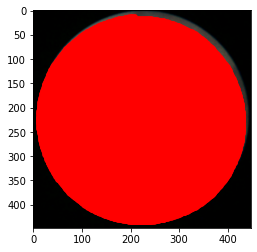

1
flowPath /content/flow_files_video03_full/000001.flo
tag 202021.25 width 448 height 448


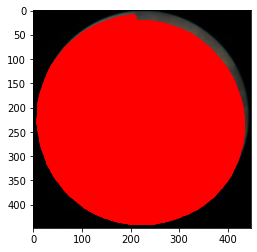

2
flowPath /content/flow_files_video03_full/000002.flo
tag 202021.25 width 448 height 448


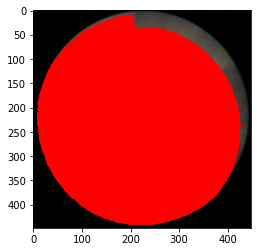

commonFeatures.shape after (132987, 2)
commonFeaturePosPerFrame.shape (4, 132987, 2)


In [ ]:
commonFeatures, PositionOfCommonFeaturesInImages, isPixelCommonMask =getCommonFeaturesPerOptim(0, amount_of_images_per_optim , True)

In [ ]:
PositionOfCommonFeaturesInImages.shape

(4, 132987, 2)

In [ ]:
raise Exception("Sorry, no numbers below zero")

Exception: ignored

## Perform optimization

Perform Optimization

debug optimization

1.   Check cost function - looks okay
2.   Check jacobian - looks okay
3.   Get cost function value before start 
4.   Get cost function value at the end

Optimization is fine, it just would not work as the correspondences between images are not entirely correct for using reprojection error

I am going to try a dense method that uses intensity based method now and see how that works


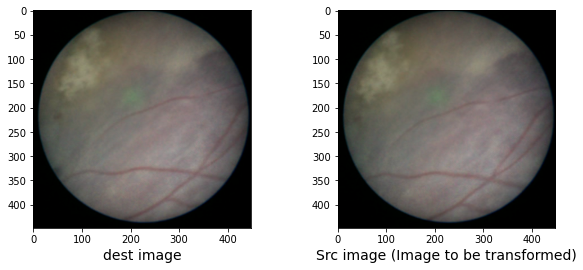

In [ ]:
destImgPath = "/content/video03/anon003_12683.png"
srcImgPath = "/content/video03/anon003_12684.png"

srcImg, destImg = inputAndVisualizeStitchPair(srcImgPath, destImgPath, showImages)
I, J = getCameraPixels(destImg)
srcImgPts = srcImg[I, J]
destImgPts = destImg[I, J]

In [ ]:
# afMapper = cv2.reg_MapperGradAffine()
# afMapperPyramid	=	cv2.reg_MapperPyramid(afMapper)

# helpAffine = cv2.reg_MapAffine(	H_array[22, 0:2, 0:2], H_array[22][0:2, 2].reshape((2,1))	)

# x = afMapper.calculate(srcImgPts.astype(np.float32), destImgPts.astype(np.float32), reg_MapAffine)

# afOnly = cv2.reg.MapTypeCaster_toAffine(x)

In [ ]:
# af = np.concatenate((afOnly.getLinTr(), afOnly.getShift()), axis = 1)
# af

In [ ]:
afMapper = cv2.reg_MapperGradAffine()
afMapperPyramid	=	cv2.reg_MapperPyramid(afMapper)

helpAffine = cv2.reg_MapAffine(	H_array[22, 0:2, 0:2], H_array[22][0:2, 2].reshape((2,1))	)

x = afMapperPyramid.calculate(srcImg.astype(np.float32), destImg.astype(np.float32), helpAffine )

pyrOnly = cv2.reg.MapTypeCaster_toAffine(x)

In [ ]:
pr = np.concatenate((pyrOnly.getLinTr(), pyrOnly.getShift()), axis = 1)
pr

array([[ 0.9994743 ,  0.01503908, -3.33606343],
       [-0.01556771,  0.99919435,  3.74105294]])

In [ ]:
H_array[22]

array([[ 1.01752069,  0.02397086,  8.34921437],
       [-0.01546208,  0.9941517 , -3.7111246 ]])

Visualize stitch


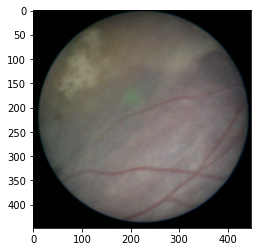

In [ ]:
visualizeStitch(srcImg, destImg, pr, 0, showImages)

In [ ]:
pyrOnly.getShift()

array([[ 3.40820162],
       [-3.75480906]])

In [ ]:
b = H_array[22]
b

array([[ 1.01752069,  0.02397086,  8.34921437],
       [-0.01546208,  0.9941517 , -3.7111246 ]])

In [ ]:
H_array[22][0:2, 2].reshape((2,1))

array([[ 8.34921437],
       [-3.7111246 ]])

Visualize stitch


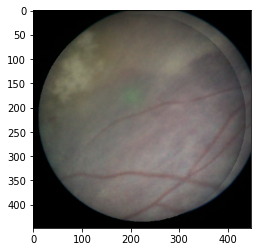

In [ ]:
visualizeStitch(srcImg, destImg, H_array[22], 0, showImages)

In [ ]:
def fun_affine_batch(h, x, x_ref, size):
  # h = vector of the h values
  # x = size*n by 2 matrix of points x size times
  # x_ref = points in reference frame size*n by 2

  r = x_ref.shape[0]//size
  H = np.reshape(h, (size,2,3))
  x_tild_full = np.empty((size*r, 2))
  

  for i in range(size):
    begin = i*r
    end = (i+1)*r
    x_frame = x[begin:end ,:]
    x_tild = np.vstack(( x_frame.T ,np.ones(r) )) 
    x_tild = np.matmul(H[i], x_tild) 
    x_tild = x_tild.T
    x_tild_full[begin:end ,:] = x_tild
  
  residual =  x_ref.flatten() - x_tild_full.flatten()

  return residual

In [ ]:
def jac_LM_Affine_batch(h, x, x_ref, size):

    def jac_fun1(inp_x, inp_h):
        # h = [h11, h12, h13, h21, h22, h23]
        # x = [x1,y1]
        

        # computing deps/da11 ....deps/dh33
        out = np.zeros_like(inp_h)
        out[0] = -1 * inp_x[0]  # deps/da11
        out[1] = -1 * inp_x[1]  #deps/da12
        out[2] = -1  # deps/b1
              

        return out

    def jac_fun2(inp_x, inp_h):
        # h = [h11, h12, h13, h21, h22, h23]
        # x = [x1,y1]
      

        # computing deps/dh11 ....deps/dh33
        out = np.zeros_like(inp_h)
        out[3] = -1 * inp_x[0]  # deps/dh21
        out[4] = -1 * inp_x[1] # deps/dh22
        out[5] = -1  # deps/dh23

        return out

    jac_full = np.zeros((2*x.shape[0],size*6))
    H = h.reshape((size, 6))
    r = x_ref.shape[0]//size

    for i in range(size):
      begin = i*r
      end = (i+1)*r
      
      x_frame = x[begin:end ,:]

      jac_eps_1 = np.apply_along_axis(jac_fun1, 1, x_frame, H[i])
      jac_eps_2 = np.apply_along_axis(jac_fun2, 1, x_frame, H[i])


      jac_out = np.empty((jac_eps_1.shape[0] + jac_eps_2.shape[0], jac_eps_1.shape[1]))
      jac_out[0::2] = jac_eps_1
      jac_out[1::2] = jac_eps_2

      c_begin = i*6
      c_end = (i+1)*6

      jac_full[2*begin:2*end,c_begin:c_end ] = jac_out

    return jac_full

#### Test cost and residual

In [ ]:
currentOptimIndex = 0
begin = currentOptimIndex * count
end = (currentOptimIndex+1) * count

H_per_optim = np.zeros((amount_of_images_per_optim,2,3 ) )
H_per_optim[0:3] = H_array[begin:end]
H_per_optim[3] = H_array_batch[currentOptimIndex]

x_inp = np.concatenate((PositionOfCommonFeaturesInImages[1],
                    PositionOfCommonFeaturesInImages[2],
                    PositionOfCommonFeaturesInImages[3],
                    PositionOfCommonFeaturesInImages[3]) , axis=0)
x_ref = np.concatenate((PositionOfCommonFeaturesInImages[0],
                        PositionOfCommonFeaturesInImages[1],
                        PositionOfCommonFeaturesInImages[2],
                        PositionOfCommonFeaturesInImages[0]) , axis=0)



sol = optimize.least_squares(fun_affine_batch, H_per_optim.flatten(), args=(x_inp, x_ref, amount_of_images_per_optim), method='lm',
                              jac=jac_LM_Affine_batch)

residual_before = fun_affine_batch(H_per_optim.flatten(), x_inp, x_ref, amount_of_images_per_optim)
cost_before = 0.5 * np.sum(residual_before**2)

cost_after = sol.cost

print('cost before is ', cost_before)
print('cost after is ', cost_after)

H_optimized = sol.x.reshape((4,2,3))
print(H_optimized[0:3])


In [ ]:
# residual = fun_affine_batch(H_optimized.flatten(), x_inp, x_ref, amount_of_images_per_optim)
# cost = np.sum(residual**2)
# cost
cost = np.sum( np.square(residual))
0.5 *cost

In [ ]:
new_H_array = np.zeros_like(H_array)
print(new_H_array.shape)

In [ ]:
def performOptimization():
  count = amount_of_images_per_optim - 1
  for currentOptimIndex in range(len(flowPaths_batch)):
    commonFeatures, PositionOfCommonFeaturesInImages, isPixelCommonMask = getCommonFeaturesPerOptim(currentOptimIndex,
                                                                          amount_of_images_per_optim , False)
    

    begin = currentOptimIndex * count
    end = (currentOptimIndex+1) * count

    H_per_optim = np.zeros((amount_of_images_per_optim,2,3 ) )
    H_per_optim[0:3] = H_array[begin:end]
    H_per_optim[3] = H_array_batch[currentOptimIndex]

    if currentOptimIndex == (middle_num_batch-1):
      PositionOfCommonFeaturesInImages[3] = PositionOfCommonFeaturesInImages[3] + [padding_size, padding_size]
    elif currentOptimIndex == middle_num_batch:
      PositionOfCommonFeaturesInImages[0] = PositionOfCommonFeaturesInImages[0] + [padding_size, padding_size]
    

    x_inp = np.concatenate((PositionOfCommonFeaturesInImages[1],
                        PositionOfCommonFeaturesInImages[2],
                        PositionOfCommonFeaturesInImages[3],
                        PositionOfCommonFeaturesInImages[3]) , axis=0)
    x_ref = np.concatenate((PositionOfCommonFeaturesInImages[0],
                            PositionOfCommonFeaturesInImages[1],
                            PositionOfCommonFeaturesInImages[2],
                            PositionOfCommonFeaturesInImages[0]) , axis=0)


    sol = optimize.least_squares(fun_affine_batch, H_per_optim.flatten(), args=(x_inp, x_ref, amount_of_images_per_optim), method='lm',
                                  jac=jac_LM_Affine_batch)
  
    H_optimized = sol.x.reshape((4,2,3))
    new_H_array[begin:end] = H_optimized[0:3]


performOptimization()

In [ ]:
print(new_H_array[24:27])
print(H_array[24:27])

### Save H for optimization

In [ ]:
np.save('new_H_array_video03', new_H_array)

In [ ]:
H_global_optimized = getHGlobal(new_H_array)

In [ ]:
srcImg = cv2.imread('/content/video03/anon003_12661.png')
srcImg = cv2.cvtColor(srcImg,cv2.COLOR_BGR2RGB)
srcImg_gray = cv2.cvtColor(srcImg, cv2.COLOR_RGB2GRAY)

destImg = cv2.imread('/content/video03/anon003_12685.png')
destImg = cv2.cvtColor(destImg,cv2.COLOR_BGR2RGB)
destImg_gray = cv2.cvtColor(destImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(10,5))
ax1.imshow(destImg, cmap="gray")
ax1.set_xlabel("dest image", fontsize=14)

ax2.imshow(srcImg, cmap="gray")
ax2.set_xlabel("Src image (Image to be transformed)", fontsize=14)

plt.show()

In [ ]:
!mkdir globalRegistrationTransparent

In [ ]:
def globalImageRegistration(srcImg, destImg, index, imageName, padding=padding_size):
  ht, wd, cc= destImg.shape

  ww = wd + (2*padding)
  hh = ht + (2*padding)

  xx = (ww - wd) // 2
  yy = (hh - ht) // 2

  srcImg = cv2.bitwise_and(srcImg, srcImg, mask=mask_im)
  
  result = cv2.warpPerspective(srcImg, H_global_optimized[index], (ww, hh))

  return result

In [ ]:
for i in range(len(fullImgPaths) - 1):
  destImgPath = fullImgPaths[middle_num] #the first image
  srcImgPath =  fullImgPaths[i];
  srcImg, destImg = inputAndVisualizeStitchPair(srcImgPath, destImgPath, False)

  imageName = Path(fullImgPaths[i]).name
  if (i == middle_num):
    src = globalRegistrationFirstImage(destImg, imageName)
  else:
    src = globalImageRegistration(srcImg, destImg, i, imageName)
  getTransparentImg(src, imageName)

In [ ]:
!zip -r /content/globalRegistration_optim.zip /content/globalRegistrationTransparent